# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (9,5)
plt.rc('font', family='Arial')
plt.style.use('classic')

C:\Users\Dmitry\Miniconda3\envs\ml\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

Загружаем данные monthly-australian-wine-sales.csv, парсим даты

In [7]:
df = pd.read_csv(r"monthly-australian-wine-sales.csv", index_col=["month"], parse_dates=["month"])
df.head().T
df.tail().T
df.shape

month  1980-01-01  1980-02-01  1980-03-01  1980-04-01  1980-05-01
sales       15136       16733       20016       17708       18019

month  1994-04-01  1994-05-01  1994-06-01  1994-07-01  1994-08-01
sales       26323       23779       27549       29660       23356

(176, 1)

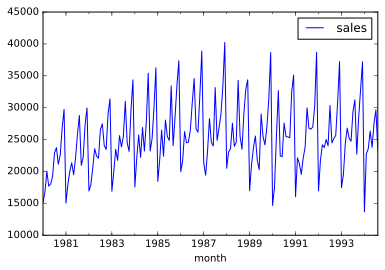

In [9]:
_ = df.plot()

Проверка стационарности и STL-декомпозиция ряда:

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Критерий Дики-Фуллера: p=0.051161


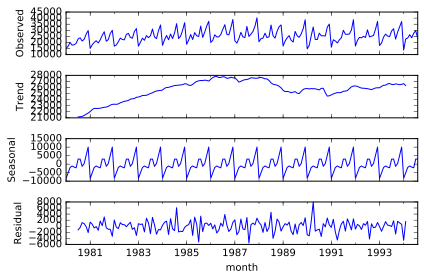

In [11]:
_ = seasonal_decompose(df).plot()
pvalue = adfuller(df.values.reshape(-1,))[1]

print(f"Критерий Дики-Фуллера: p={pvalue:.5}")

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [12]:
df_transformed, lmbda = stats.boxcox(df.values.reshape(-1))
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda:.6}")
print(f"Критерий Дики-Фуллера: p={adfuller(df_transformed)[1]:.5}")
_ = plt.plot(df_transformed)

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


In [13]:
df['transformed'] = df_transformed
df.head().T

month          1980-01-01    1980-02-01    1980-03-01    1980-04-01  \
sales        15136.000000  16733.000000  20016.000000  17708.000000   
transformed     36.999037     37.989416     39.817812     38.559061   

month          1980-05-01  
sales        18019.000000  
transformed     38.735721

### Стационарность

Что с гипотезей нестационарности и трендом?
Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

In [14]:
df['t_shifted'] = df.transformed - df.transformed.shift(12)

_ = seasonal_decompose(df.t_shifted[12:]).plot()

print(f"Критерий Дики-Фуллера: p={adfuller(df.t_shifted[12:].values.reshape(-1,))[1]:.5}")

Критерий Дики-Фуллера: p=0.12832


Что с гипотезей нестационарности и трендом?
Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=2.1237e-06


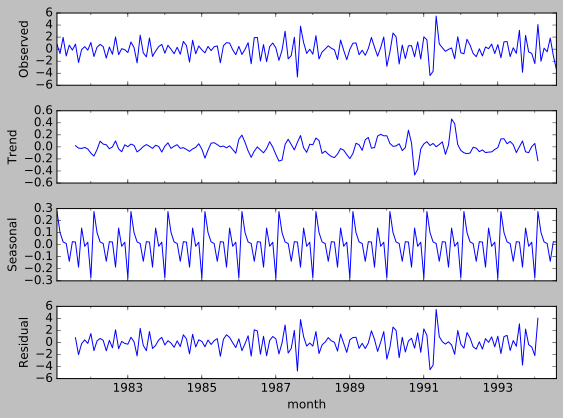

In [42]:
df['t_shifted2'] = df.t_shifted - df.t_shifted.shift(1)

_ = seasonal_decompose(df.t_shifted2[13:]).plot()

print(f"Критерий Дики-Фуллера: p={adfuller(df.t_shifted2[13:].values.reshape(-1,))[1]:.5}")

Принимаем ли гипотезу нестационарности?

In [ ]:
# ?

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

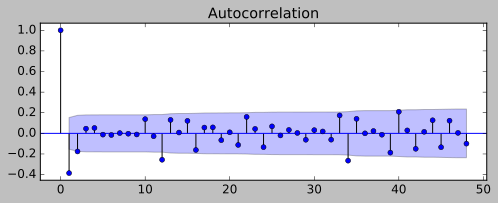

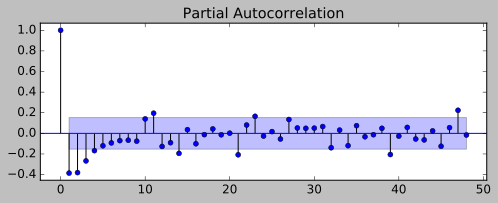

In [46]:
_ = sm.graphics.tsa.plot_acf(df.t_shifted2[13:].values.squeeze(), 
                             lags=48, ax=plt.subplot(211))
_ = plt.show()

_ = sm.graphics.tsa.plot_pacf(df.t_shifted2[13:].values.squeeze(), 
                              lags=48, ax=plt.subplot(212))
_ = plt.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [47]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [48]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [63]:
%%time

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    model = SARIMAX(df.sales.values)
    try:
        # обучаем модель tsa.statespace.SARIMAX
        model.fit(param)
    выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

AttributeError: 'SARIMAX' object has no attribute 'aic'

Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
24  (2, 1, 0, 1)  1007.801553
26  (2, 1, 1, 1)  1008.786538
28  (2, 2, 0, 1)  1009.284267
36  (3, 1, 0, 1)  1009.723537
6   (0, 1, 1, 1)  1010.126754


Лучшая модель:

In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -498.901
Date:                            Wed, 14 Dec 2016   AIC                           1007.802
Time:                                    13:07:50   BIC                           1023.654
Sample:                                01-01-1980   HQIC                          1014.231
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111   

Её остатки:

Критерий Стьюдента: p=0.257989
Критерий Дики-Фуллера: p=0.000000


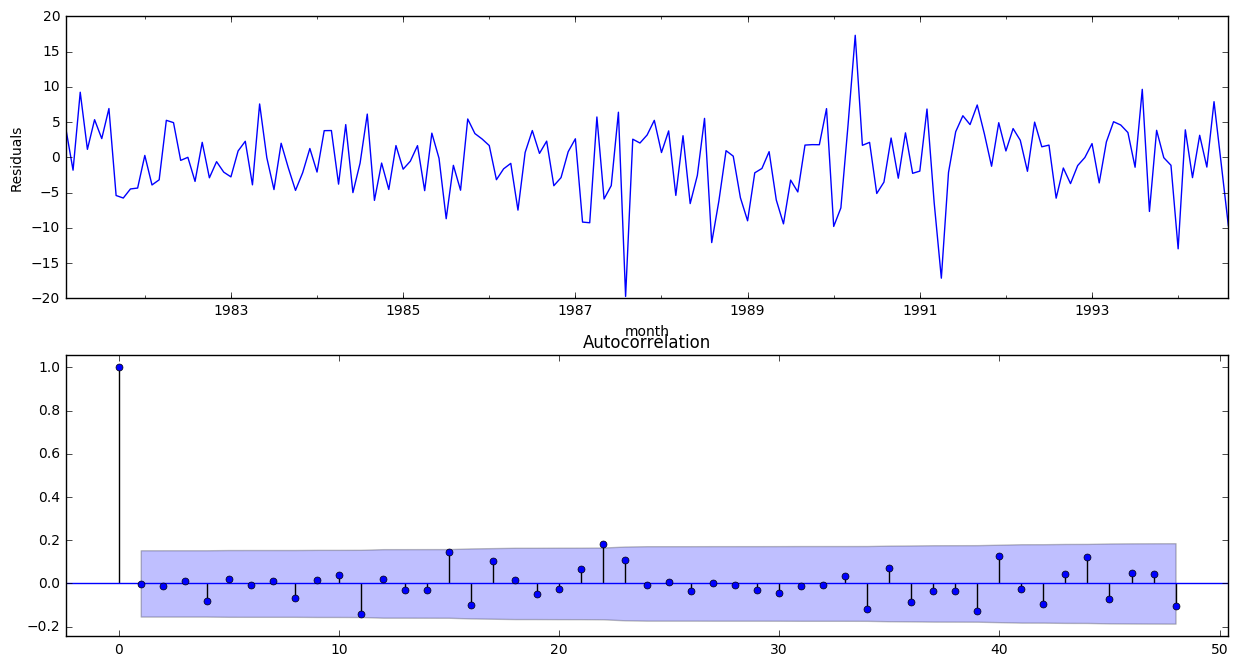

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

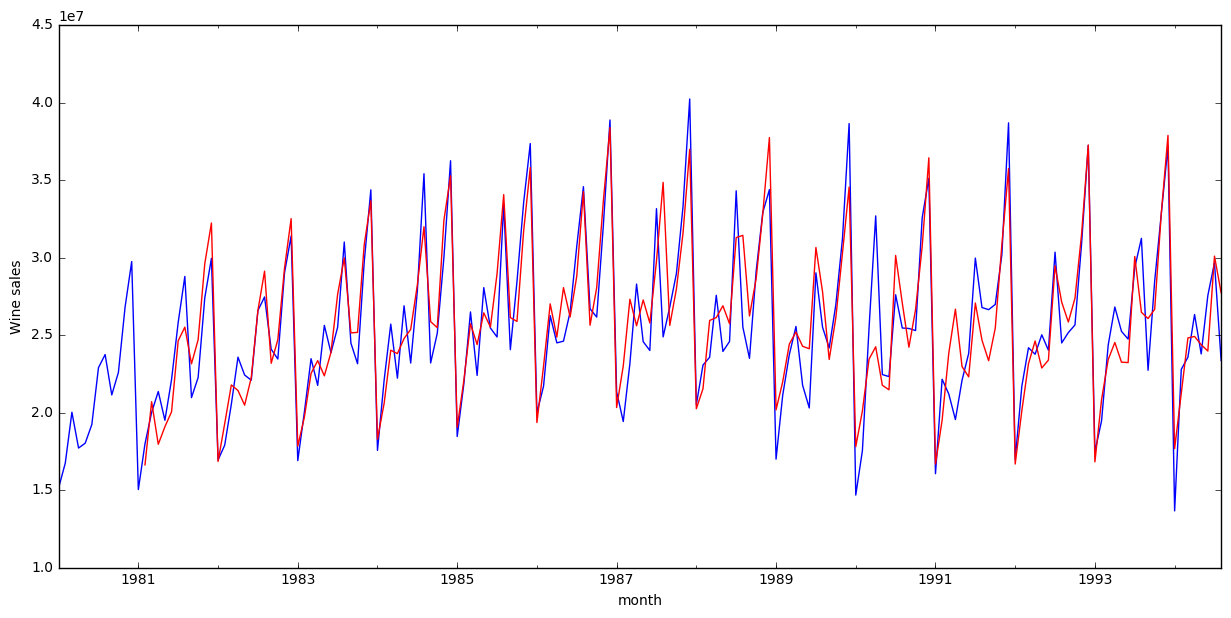

In [14]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wine.sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

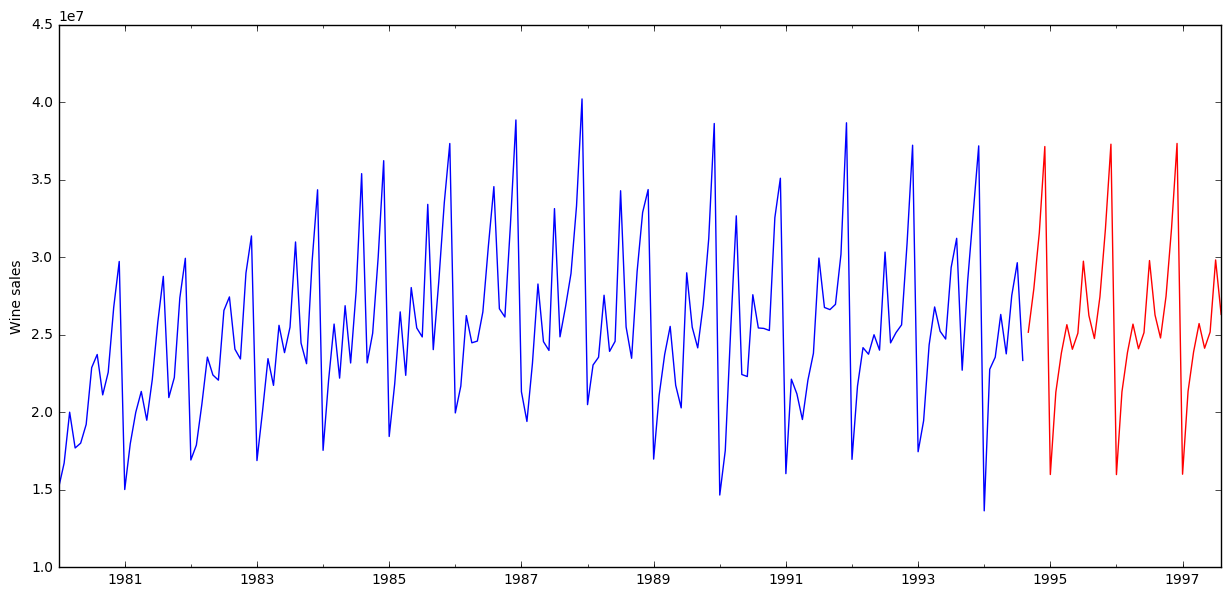

In [15]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()